# Data Exploration
## An attempt to understand the nature of the drone delivery data and extract any useful information prior to performing optimization

In [1]:
# import filename
filename = 'busy_day.in'
with open(filename) as f:
    data = [line.rstrip() for line in f]

# Get parameters
params = data[0].split()
nRow = int(params[0])
nCol = int(params[1])
nDrone = int(params[2])
nDeadline = int(params[3])
nMaxLoad = int(params[4])

# Get product weights
nProduct = int(data[1])
productID = [int(i) for i in range(nProduct)]
productWeight = [int(i) for i in data[2].split()]

# Get number of warehouse and product availability for each warehouses 
nWarehouse = int(data[3])
locWarehouse = []
prodAvaiWarehouse = []
warehouseStart = 4
warehouseEnd = warehouseStart + nWarehouse*2
for i in range(warehouseStart,warehouseEnd,2):
    locWarehouse.append([int(j) for j in data[i].split()])
    prodAvaiWarehouse.append([int(j) for j in data[i+1].split()])
    
# Get customer's orders
nOrder = int(data[warehouseEnd])
locPerOrder = []
nPerOrder = []
prodPerOrder = []
orderStart = warehouseEnd+1
orderEnd = orderStart + nOrder*3
for i in range(orderStart,orderEnd,3):
    locPerOrder.append([int(j) for j in data[i].split()])
    nPerOrder.append([int(j) for j in data[i+1].split()])
    prodPerOrder.append([int(j) for j in data[i+2].split()])

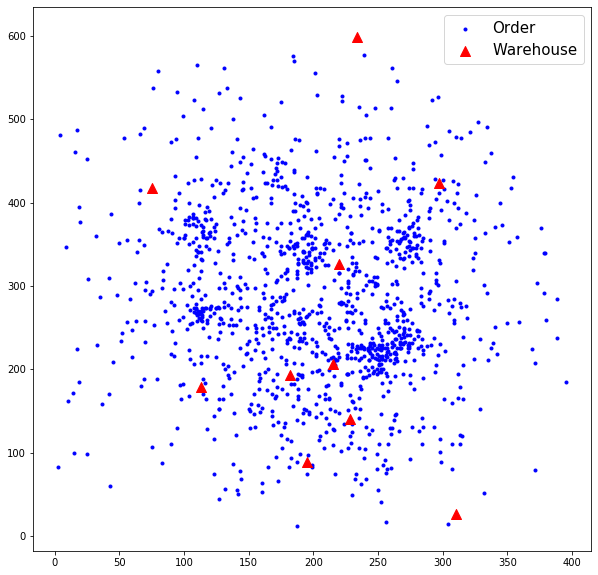

In [3]:
import matplotlib.pyplot as plt
import numpy as np

## Plot the location of orders and warehouse
locWarehouse_np = np.array(locWarehouse)
locPerOrder_np = np.array(locPerOrder)

h = plt.figure(figsize=(10,10))
h = plt.scatter(locPerOrder_np[:,0],locPerOrder_np[:,1],c='b',marker='.',label='Order')
h = plt.scatter(locWarehouse_np[:,0],locWarehouse_np[:,1],c='r',marker='^',s=100,label='Warehouse')
h = plt.legend(prop={'size': 15})

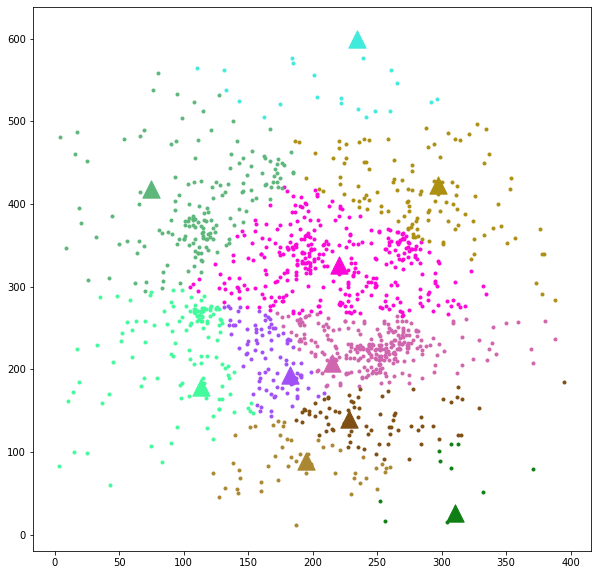

In [4]:
from sklearn.neighbors import NearestNeighbors
import random

## Classify order based on the nearest warehouse / Voronoi graph
neigh = NearestNeighbors(n_neighbors=1, radius=50)
neigh.fit(locWarehouse_np)

nearestIdx = neigh.kneighbors(locPerOrder_np, 1, return_distance=False)

plt.figure(figsize=(10,10))
for iw in range(nWarehouse):
    boolWarehouse = (nearestIdx==iw).reshape((-1,))
    orderWarehouse = locPerOrder_np[boolWarehouse,:]
    color = "#%06x" % random.randint(0, 0xFFFFFF)
    plt.scatter(orderWarehouse[:,0],orderWarehouse[:,1],c=color,marker='.')
    plt.scatter(locWarehouse_np[iw,0],locWarehouse_np[iw,1],c=color,marker='^',s=300)
    
### Based on the figure below, one strategy to solve the drone delivery is to divide the 
### problem into multiple independent sub-problem, where each sub problem tries to solve 
### one warehouse and all of its nearest orders.

### However, for this strategy to work, a few drones needs to be allocated to transfer goods
### among the wareshouses only, since most warehouses do not have enough resources to satisfy
### their orders.

### Let's try to perform a simple algorithm to allocate resources among warehouses such that 
### all wareshouses will have enough resources to complete all orders.

In [22]:
## Count the resources/products needed for each warehouses in order to fulfill all orders nearest to the warehouse
prodReqWarehouse = np.zeros((nWarehouse,nProduct), dtype=int)

for i in range(nOrder):
    idxWarehouse = nearestIdx[i]
    for j in prodPerOrder[i]:
        prodReqWarehouse[idxWarehouse,j] += 1
        
# Find the products need for each warehouse
prodNeedWarehouse = prodReqWarehouse - prodAvaiWarehouse
prodNeedWarehouse[prodNeedWarehouse<0]=0

# Find the products that are extra for each warehouse
prodExtraWarehouse = prodAvaiWarehouse - prodReqWarehouse
prodExtraWarehouse[prodExtraWarehouse<0]=0


## allocate resources to warehouses based on orders. Priority are:
# 1) higher number of order in warehouse gets to allocate resources first
# 2) resource allocation based on distance between warehouses

# find n nearest warehouses
neigh = NearestNeighbors(n_neighbors=nWarehouse, radius=100)
neigh.fit(locWarehouse_np)
nearestWarehousesAll = neigh.kneighbors(locWarehouse_np, nWarehouse, return_distance=False)

# sort warehouse based on the number of order
nOrderWarehouse = np.zeros((nWarehouse,))
for i in range(nWarehouse):
    boolWarehouse = (nearestIdx==i).reshape((-1,))
    nOrderWarehouse[i] = locPerOrder_np[boolWarehouse,:].shape[0]

idxOrder = np.argsort(nOrderWarehouse*-1)
allocateWarehousesAll = np.zeros((nWarehouse,nWarehouse,nProduct)) # row: receive, col: provide, hei: product
pNeedWare = prodNeedWarehouse.copy()
pExtraWare = prodExtraWarehouse.copy()

for idx in idxOrder:
    nearestWarehouses = nearestWarehousesAll[idx,:]
    for j in range(nProduct):
        if pNeedWare[idx,j] > 0:   # check if receiving warehouse need this product
            for idxWarehouse in nearestWarehouses[1:]:
                if pExtraWare[idxWarehouse,j] > 0:   # check if giving warehouse has extra product
                    if pExtraWare[idxWarehouse,j] >= pNeedWare[idx,j]: 
                        # if giving warehouse has equal or more product than receiving warehouse
                        amount = pExtraWare[idxWarehouse,j] - pNeedWare[idx,j]
                        allocateWarehousesAll[idx,idxWarehouse,j] = pNeedWare[idx,j]
                        pExtraWare[idxWarehouse,j] = amount
                        pNeedWare[idx,j] = 0
                        break
                    else:
                        # if giving warehouse has less product than receiving warehouse
                        amount = pNeedWare[idx,j] - pExtraWare[idxWarehouse,j]                    
                        allocateWarehousesAll[idx,idxWarehouse,j] = pExtraWare[idxWarehouse,j]
                        pExtraWare[idxWarehouse,j] = 0
                        pNeedWare[idx,j] = amount
                        
# Check on the resource allocation
print('Resource allocations from all warehouses.')
print('For example, 38, 72, 78, and 23 items from warehouse 1, 2, 3, and 4 goes to warehouse 0.\n')
for i in range(allocateWarehousesAll.shape[0]):
    print('Warehouse %s:' % i, end='')
    print(allocateWarehousesAll[i].sum(axis=1))

                        
### Doesn't seem like the best way to allocate resources among the warehouses, since each warehouse will receive
### resources from all warehouses (huge waste of time). Still, it's a pretty good start.

Resource allocations from all warehouses.
For example, 38, 72, 78, and 23 items from warehouse 1, 2, 3, and 4 goes to warehouse 0.

Warehouse 0:[ 0. 38. 72. 78. 23. 62. 65. 65. 49. 60.]
Warehouse 1:[ 7.  0.  5.  8.  4. 10. 10.  9. 10.  8.]
Warehouse 2:[20. 12.  0. 30. 15. 21. 20. 22. 23. 13.]
Warehouse 3:[118. 100. 136.   0.  72. 228. 105. 230. 128. 100.]
Warehouse 4:[175.  99. 116. 231.   0. 303. 207. 134. 148. 311.]
Warehouse 5:[36. 30. 34. 42. 19.  0. 41. 35. 49. 29.]
Warehouse 6:[ 66. 113.  59.  66.  42.  53.   0.  60.  67.  73.]
Warehouse 7:[31. 25. 43. 39. 17. 22. 22.  0. 47. 27.]
Warehouse 8:[6. 3. 8. 7. 1. 3. 4. 4. 0. 0.]
Warehouse 9:[57. 88. 35. 55. 30. 34. 52. 56. 67.  0.]
